In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
from scipy.signal import welch
import scipy.special
from scipy.special import erfc
import math
from math import log, log2, sqrt
import ipywidgets as widgets
from ipywidgets import IntSlider, IntRangeSlider, FloatSlider, interactive, Layout, Dropdown, IntText, HBox, VBox, Output
from IPython.display import display, clear_output
from commpy.channels import awgn
import time
print("Libraries added successfully!")

Libraries added successfully!


In [2]:
# Loading animation
loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey */
                                     border-top: 12px solid #01cc97; /* Blue */
                                     border-radius: 50%;
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite;'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }
        100% { transform: rotate(360deg); }
    }
    </style>
    """
done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>
        </div>
        """
loader_html3 = widgets.HTML(
  value=loading
)
timer_html3 = widgets.HTML(
    value="Elapsed time: - seconds"
)

# Parameters
bps = 4  # bits per symbol
Nsymb = 1000  # number of simulated symbols
ns = 8  # number of samples per symbol (oversampling)

# Derived parameters
M = 2 ** bps  # number of different symbols
BR = 1  # Baud Rate
fc = 2 * M * BR  # RF frequency

# Derived parameters
nb = bps * Nsymb  # number of simulated data bits
T = 1 / BR  # one symbol period
Ts = T / ns  # oversampling period

# M frequencies in "non-coherent" distance (BR)
f = fc + BR * (np.arange(1, M + 1) - (M + 1) / 2)

# input data bits
y = np.random.randint(0, 2, nb)
x = y.reshape((Nsymb, bps))

t = np.arange(0, len(x) * T, T)  # time vector on the T grid
tks = np.arange(0, T, Ts)  # oversampling time vector

# FSK signal
s = []
A = np.sqrt(2 / T / ns)
for k in range(len(x)):
    fk = f[int(''.join(map(str, x[k])), 2)]
    tk = (k * T) + tks
    s.append(np.sin(2 * np.pi * fk * tk))
s = np.concatenate(s)


def calculate_errors(EbNo_range):
    # Start timer
    loader_html3.value = loading
    start_time = time.time()

    clear_output(wait=True)
    EbNo_values = list(EbNo_range)
    for EbNo in EbNo_values:
        # Calculate SNR
        SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

        # add noise to the FSK (passband) signal
        noisy_signal = awgn(s, SNR)

        # FSK receiver
        xr = []
        for k in range(len(noisy_signal) // ns):
            tk = (k * T) + tks
            sk = noisy_signal[k * ns:(k + 1) * ns]
            smi = []
            for fi in f:
                si = np.sin(2 * np.pi * fi * tk)
                smi.append(np.sum(sk * si))
            j = np.argmax(smi)
            xr.append([int(bit) for bit in bin(j)[2:].zfill(bps)])
        xr = np.array(xr).reshape((Nsymb, bps))

        # count errors
        errors = np.sum(x != xr)

        # Display the number of errors for the current EbNo value
        print(f'Number of errors for EbNo = {EbNo} dB: {errors}')
        # Show elapsed time
        elapsed_time = time.time() - start_time
        timer_html3.value = f"Elapsed time: {elapsed_time:.2f} seconds"
        loader_html3.value = done

# Create the range slider widget
EbNo_slider = IntRangeSlider(
    value=[8, 10],
    min=0,
    max=20,
    step=1,
    description='EbNo (dB):',
    continuous_update=False,
    layout=Layout(width='500px')
)

# Group the loader and timer together (they will appear next to each other horizontally)
loader_timer_box = widgets.VBox([loader_html3, timer_html3], layout=widgets.Layout(margin='0 0 0 20px', width='auto'))

# Create interactive widget
interactive_plot = interactive(calculate_errors, EbNo_range=EbNo_slider)

input_widgets = VBox([EbNo_slider], layout=Layout(flex='1 1 auto', width='auto'))
plot_output = interactive_plot.children[-1]  # The output plot

# Group the loader and timer together (they will appear next to each other horizontally)
loader_timer_box = widgets.VBox([loader_html3, timer_html3], layout=widgets.Layout(margin='0 0 0 20px', width='auto'))

# Create a VBox that includes both the input widgets and the loading animation
inputs_and_loader = HBox([input_widgets, loader_timer_box], layout=Layout(align_items='center'))

# Create an HBox to hold everything in a horizontal layout
ui = VBox([inputs_and_loader, plot_output])

# Display the UI components
clear_output(wait=True)  # Clear the previous output
display(ui)

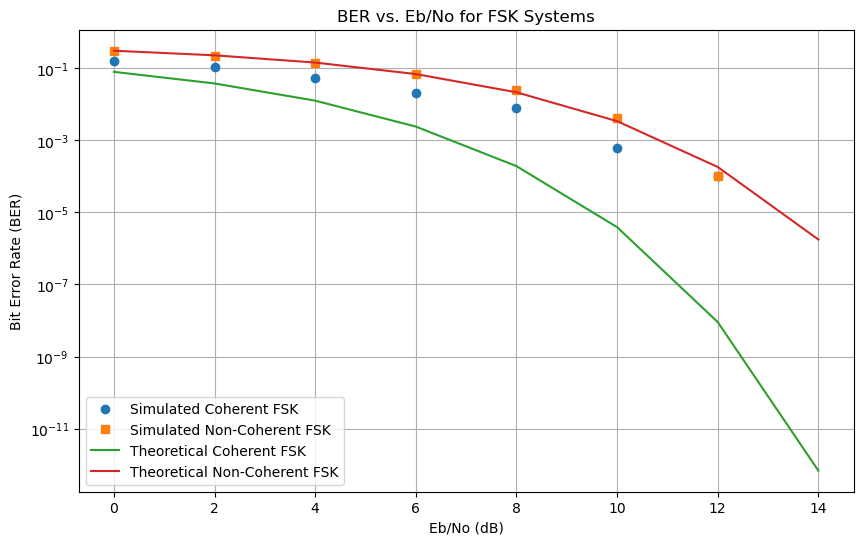

In [3]:
def fsk_errors(bps, Nsymb, ns, EbNo):
    # Input parameters
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # M frequencies in "non-coherent" distance (BR)
    f = fc + BR * (np.arange(1, M + 1) - (M + 1) / 2)

    # awgn channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)
    x = y.reshape((Nsymb, bps))

    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)  # oversampling time vector

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)
    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s.append(np.sin(2 * np.pi * fk * tk))
    s = np.concatenate(s)

    # add noise to the FSK (passband) signal
    s = awgn(s, SNR)

    # FSK receiver
    xr = []
    for k in range(len(s) // ns):
        tk = (k * T) + tks
        sk = s[k * ns:(k + 1) * ns]
        smi = []
        for fi in f:
            si = np.sin(2 * np.pi * fi * tk)
            smi.append(np.sum(sk * si))
        j = np.argmax(smi)
        xr.append([int(bit) for bit in bin(j)[2:].zfill(bps)])
    xr = np.array(xr).reshape((Nsymb, bps))

    # count errors
    errors = np.sum(x != xr)
    return errors

def fsk_errors_non_coh(bps, Nsymb, ns, EbNo):
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period
    f = fc + BR * (np.arange(1, M + 1) - (M + 1) / 2)  # M frequencies

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)  # Ensure integer dimensions
    x = y.reshape((-1, bps))
    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = np.array([])
    A = np.sqrt(2 / T / ns)
    for k in range(len(x)):
        fk = f[int("".join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s = np.concatenate((s, np.sin(2 * np.pi * fk * tk)))

    # add noise to the FSK (passband) signal
    s = awgn(s, SNR)

    # FSK receiver
    # Non-coherent demodulation
    xr = np.array([])
    for k in range(len(s) // ns):
        tk = (k * T) + tks
        sk = s[k * ns:(k + 1) * ns]
        sm = []
        for i in range(M):
            si = np.sin(2 * np.pi * (f[i] * tk))
            sq = np.cos(2 * np.pi * (f[i] * tk))
            smi = np.sum(sk * si)
            smq = np.sum(sk * sq)
            sm.append(np.sqrt(smi ** 2 + smq ** 2))
        j = np.argmax(sm)
        xr = np.concatenate((xr, np.array(list(np.binary_repr(j, width=bps)), dtype=int)))

    # count errors
    x_reshaped = x.reshape(-1)
    xr_reshaped = xr.reshape(-1)
    err = np.not_equal(x_reshaped, xr_reshaped)
    errors = np.sum(err)
    return errors

# BER simulation function
def simulate_ber(bps, Nsymb, ns, EbNo_values, coherent=True):
    ber = []
    for EbNo in EbNo_values:
        errors = 0
        for _ in range(10):  # averaging over 10 iterations
            if coherent:
                errors += fsk_errors(bps, Nsymb, ns, EbNo)
            else:
                errors += fsk_errors_non_coh(bps, Nsymb, ns, EbNo)
        ber.append(errors / (Nsymb * bps * 10))
    return ber

# Theoretical BER for M-ary coherent and non-coherent FSK
def theoretical_ber_coh(EbNo, M):
    return (M - 1) / M * erfc(np.sqrt(EbNo * np.log2(M)))

def theoretical_ber_non_coh(EbNo, M):
    return (M - 1) / M * np.exp(-EbNo * np.log2(M) / 2)

# Parameters
bps = 1  # bits per symbol (binary FSK)
Nsymb = 1000  # number of symbols
ns = 100  # oversampling factor
EbNo_dB_sim = np.arange(0, 13, 2)  # Eb/No values in dB for simulation
EbNo_dB_theory = np.arange(0, 15, 2)  # Eb/No values in dB for theoretical
EbNo_sim = 10 ** (EbNo_dB_sim / 10)  # convert dB to linear for simulation
EbNo_theory = 10 ** (EbNo_dB_theory / 10)  # convert dB to linear for theoretical
M = 2 ** bps  # M-ary FSK

# Simulate BER
ber_coh_sim = simulate_ber(bps, Nsymb, ns, EbNo_dB_sim, coherent=True)
ber_non_coh_sim = simulate_ber(bps, Nsymb, ns, EbNo_dB_sim, coherent=False)

# Theoretical BER
ber_coh_theory = theoretical_ber_coh(EbNo_theory, M)
ber_non_coh_theory = theoretical_ber_non_coh(EbNo_theory, M)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.semilogy(EbNo_dB_sim, ber_coh_sim, 'o', label='Simulated Coherent FSK')
plt.semilogy(EbNo_dB_sim, ber_non_coh_sim, 's', label='Simulated Non-Coherent FSK')
plt.semilogy(EbNo_dB_theory, ber_coh_theory, label='Theoretical Coherent FSK')
plt.semilogy(EbNo_dB_theory, ber_non_coh_theory, label='Theoretical Non-Coherent FSK')

plt.title('BER vs. Eb/No for FSK Systems')
plt.xlabel('Eb/No (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which='both')
plt.legend()
plt.show()

In [4]:
# Loading animation
loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey */
                                     border-top: 12px solid #01cc97; /* Blue */
                                     border-radius: 50%;
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite;'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }
        100% { transform: rotate(360deg); }
    }
    </style>
    """
done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>
        </div>
        """
loader_html3 = widgets.HTML(
  value=loading
)
timer_html3 = widgets.HTML(
    value="Elapsed time: - seconds"
)


# Define the function to be called when widgets change
def update_plot(fsklvl, Nsymb, EbNo):
    # Start the timer
    loader_html3.value = loading
    start_time = time.time()

    clear_output(wait=True)
    
    bps = int(math.log2(fsklvl))
    # Derived parameters for coherent FSK
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency
    ns = 80  # samples per symbol
    nb = bps * Nsymb  # number of simulated data bits
    f = fc + (BR / 2) * ((np.arange(1, M + 1)) - (M + 1) / 2)
    fmax = np.max(f)
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # awgn channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)
    x = np.reshape(y, (len(y) // bps, bps))

    # time vectors
    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)  # oversampling time vector

    # FSK signal generation
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s_coherent = np.concatenate(s)

    # Plotting power spectral density for coherent FSK
    frequencies_coherent, Pxx_coherent = welch(s_coherent, fs=ns*BR, nperseg=50000, noverlap=25000)

    # Derived parameters for non-coherent FSK
    ns = 90  # samples per symbol
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # Frequencies in "non-coherent" distance
    f = fc + BR * ((np.arange(1, M + 1)) - (M + 1) / 2)
    fmax = np.max(f)

    # awgn channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)
    x = np.reshape(y, (len(y) // bps, bps))

    # time vectors
    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)  # oversampling time vector

    # FSK signal generation
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s_non_coherent = np.concatenate(s)

    # Plotting power spectral density for non-coherent FSK
    frequencies_non_coherent, Pxx_non_coherent = welch(s_non_coherent, fs=ns*BR, nperseg=50000)

    # Plot both side by side
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    axs[0].semilogy(frequencies_coherent, Pxx_coherent, linewidth=0.5)
    axs[0].set_title("FSK Coherent")
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Power Spectral Density (dB/Hz)")
    axs[0].grid(True)

    axs[1].semilogy(frequencies_non_coherent, Pxx_non_coherent, linewidth=0.5)
    axs[1].set_title("Non Coherent FSK")
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Power Spectral Density (dB/Hz)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    # Stop the timer and update the timer HTML
    elapsed_time = time.time() - start_time
    timer_html3.value = f"Elapsed time: {elapsed_time:.2f} seconds"
    # Update the loading animation to done
    loader_html3.value = done

fsklvl_dropdown=Dropdown(options=[2, 4, 8, 16, 32], value=4, description='FSK levels', style={'description_width': 'initial'}, layout=Layout(flex='1 1 auto', width='auto'), continuous_update=False)
Nsymb_slider=IntSlider(value=10000, min=1000, max=50000, step=1000, description='Nsymb', style={'description_width': 'initial'}, layout=Layout(flex='1 1 auto', width='auto'), continuous_update=False)
EbNo_slider=IntSlider(value=8, min=0, max=20, step=1, description='EbNo', style={'description_width': 'initial'}, layout=Layout(flex='1 1 auto', width='auto'), continuous_update=False)

# Create interactive interface
interactive_plot = interactive(update_plot, fsklvl=fsklvl_dropdown, Nsymb=Nsymb_slider, EbNo=EbNo_slider)

input_widgets = VBox([fsklvl_dropdown, Nsymb_slider, EbNo_slider], layout=Layout(flex='1 1 auto', width='auto'))
plot_output = interactive_plot.children[-1]  # The output plot

# Group the loader and timer together (they will appear next to each other horizontally)
loader_timer_box = widgets.VBox([loader_html3, timer_html3], layout=widgets.Layout(margin='0 0 0 20px', width='auto'))

# Create a VBox that includes both the input widgets and the loading animation
inputs_and_loader = HBox([input_widgets, loader_timer_box])

# Create an HBox to hold everything in a horizontal layout
ui = VBox([inputs_and_loader, plot_output])

# Display the UI components
clear_output(wait=True)  # Clear the previous output
display(ui)